In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Copy the zip file and unzip locally into memory

In [2]:
!cp /content/drive/My\ Drive/GANS/cars_dataset.zip cars_dataset.zip

In [3]:
!unzip cars_dataset.zip 

Archive:  cars_dataset.zip
   creating: cars_dataset/
  inflating: cars_dataset/acura_PNG100.png  
  inflating: cars_dataset/acura_PNG109.png  
  inflating: cars_dataset/acura_PNG111.png  
  inflating: cars_dataset/acura_PNG112.png  
  inflating: cars_dataset/acura_PNG113.png  
  inflating: cars_dataset/acura_PNG115.png  
  inflating: cars_dataset/acura_PNG117.png  
  inflating: cars_dataset/acura_PNG118.png  
  inflating: cars_dataset/acura_PNG119.png  
  inflating: cars_dataset/acura_PNG120.png  
  inflating: cars_dataset/acura_PNG122.png  
  inflating: cars_dataset/acura_PNG123.png  
  inflating: cars_dataset/acura_PNG126.png  
  inflating: cars_dataset/acura_PNG129.png  
  inflating: cars_dataset/acura_PNG13.png  
  inflating: cars_dataset/acura_PNG130.png  
  inflating: cars_dataset/acura_PNG15.png  
  inflating: cars_dataset/acura_PNG2.png  
  inflating: cars_dataset/acura_PNG3.png  
  inflating: cars_dataset/acura_PNG32.png  
  inflating: cars_dataset/acura_PNG33.png  
  inflati

In [4]:
!pwd
!ls

/content
cars_dataset  cars_dataset.zip	drive  sample_data


##Preprocess dataset. dataset has different dimensions and sizes. So return the 100*100 size that GANS can handle.

In [5]:
import numpy as np
import cv2
import io
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import zipfile
from PIL import Image
import sys
import torch.utils.data
import timeit
import logging
root_dir = "/content/cars_dataset"
class PreprocessImageFolderDataset(Dataset):

  def __init__(self, root_dir, transform=ToTensor()):
    'Initialization'
    self.m_root = root_dir
    self.m_transform = transform
    logging.basicConfig(filename = "/content/dataloader_timeit.log",datefmt='%H:%M:%S',level=logging.DEBUG)
    #self.g_dict_fileindex = dict()
    self.g_array_fileindex1 = []
    self.walkTheDirectory(self.m_root) 
    self.m_length = len(self.g_array_fileindex1)
  
  def walkTheDirectory(self,root_dir):
    #for root, dirs, files in os.walk('python/Lib/email'):
    # for file in files:
    #    with open(os.path.join(root, file), "r") as auto: 
   
    for path, subdirs, files in os.walk(self.m_root): # path should give the complete path till the last directory.
        for filename in files:
            #print(os.path.join(path, filename))
            full_path = os.path.join(path, filename)
            self.g_array_fileindex1.append(full_path)
            
 
  def __len__(self):
    'Denotes the total number of samples'
    return self.m_length;

  
  def __getitem__(self, idx):
    if idx >= self.m_length:
        print('index', idx, 'is bigger than the actual dataset size')
        return
        
    start_time = timeit.default_timer()

    # Pick the file from the index
    size = 128, 128
    file = self.g_array_fileindex1[idx]
    
    try:
      image = Image.open(file).convert('RGB') # even grey scale images will be converted to RGB with 3 channels
      #temporarily we will resize to 224*224
      # We need to look into meaningful way of resizing (...pyramid pooling??)
      image = image.resize((128,128), Image.ANTIALIAS)
      
      """
      #Create jpg file
      basefile=os.path.basename(file)#This comes with extension
      #split with extension
      file1, ext = os.path.splitext(basefile)
      file1 = file1 + ".jpg"
      file1 = os.path.join(dir1,file1)#complete new file path
      print('new filename=',file1)
      image.save(file1)
      """

      if self.m_transform:
        image = self.m_transform(image)
    except:
      print("exception while opening=",file)
      
    load_time = timeit.default_timer() - start_time
    
    desc = f' file={file} size={image.size} LOAD_TIME={load_time:0.3f}'
    logging.info(desc)
      
    return image, file
    
import torch
import torchvision.transforms

#import WingsFolderDataset as wingsDataset
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

root_dir = "/content/cars_dataset"

tr=transforms.Compose([
                               transforms.Resize((128,128)),
                               transforms.CenterCrop((128,128)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

data_set = PreprocessImageFolderDataset("/content/cars_dataset", transform = tr)


##GANS Discriminator and Generator

Random Seed:  999


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


device(type='cuda', index=0)

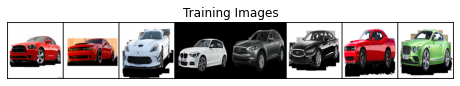

In [7]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot ="/content/cars_dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
# batch_size = 128
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr_gen = 0.0002
lr_dis = 0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

tr=transforms.Compose([
                               transforms.Resize((128,128)),
                               transforms.CenterCrop((128,128)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])


dataset = PreprocessImageFolderDataset("/content/cars_dataset", transform = tr)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

dataset

device


In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

# # Create the generator
# netG = Generator(ngpu).to(device)
#
# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))
#
# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
# netG.apply(weights_init)
#
# # Print the model
# print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

# # Create the Discriminator
# netD = Discriminator(ngpu).to(device)
#
# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))
#
# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
# netD.apply(weights_init)
#
# # Print the model
# print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0/100][0/65]	Loss_D: 1.2664	Loss_G: 3.8070	D(x): 0.5753	D(G(z)): 0.5054 / 0.0228
[0/100][50/65]	Loss_D: 0.1709	Loss_G: 7.2296	D(x): 0.9212	D(G(z)): 0.0746 / 0.0008
epoch: 1


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[1/100][0/65]	Loss_D: 0.1244	Loss_G: 7.5133	D(x): 0.9406	D(G(z)): 0.0570 / 0.0006


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[1/100][50/65]	Loss_D: 0.0584	Loss_G: 12.4447	D(x): 0.9464	D(G(z)): 0.0000 / 0.0000
epoch: 2


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[2/100][0/65]	Loss_D: 0.5842	Loss_G: 4.5384	D(x): 0.6210	D(G(z)): 0.0038 / 0.0140
[2/100][50/65]	Loss_D: 2.2931	Loss_G: 0.9350	D(x): 0.2043	D(G(z)): 0.1152 / 0.4179
epoch: 3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[3/100][0/65]	Loss_D: 2.6692	Loss_G: 1.2976	D(x): 0.1153	D(G(z)): 0.2698 / 0.3824


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[3/100][50/65]	Loss_D: 1.1313	Loss_G: 3.2672	D(x): 0.7976	D(G(z)): 0.5573 / 0.0497
epoch: 4


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[4/100][0/65]	Loss_D: 0.7108	Loss_G: 2.7694	D(x): 0.8756	D(G(z)): 0.4231 / 0.0715


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[4/100][50/65]	Loss_D: 1.2862	Loss_G: 1.7108	D(x): 0.6580	D(G(z)): 0.5165 / 0.1983
epoch: 5


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[5/100][0/65]	Loss_D: 1.7516	Loss_G: 1.3661	D(x): 0.5643	D(G(z)): 0.6175 / 0.2662


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[5/100][50/65]	Loss_D: 2.2766	Loss_G: 2.1422	D(x): 0.3910	D(G(z)): 0.5781 / 0.1248
epoch: 6


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[6/100][0/65]	Loss_D: 1.3046	Loss_G: 1.5880	D(x): 0.4608	D(G(z)): 0.2686 / 0.2535


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[6/100][50/65]	Loss_D: 1.3798	Loss_G: 1.2391	D(x): 0.3717	D(G(z)): 0.2037 / 0.3091
epoch: 7


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[7/100][0/65]	Loss_D: 0.6123	Loss_G: 2.6704	D(x): 0.7574	D(G(z)): 0.2506 / 0.0808
[7/100][50/65]	Loss_D: 0.4273	Loss_G: 2.1075	D(x): 0.8281	D(G(z)): 0.1928 / 0.1411
epoch: 8


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[8/100][0/65]	Loss_D: 1.3542	Loss_G: 3.2241	D(x): 0.9812	D(G(z)): 0.7001 / 0.0518


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[8/100][50/65]	Loss_D: 1.1525	Loss_G: 1.7965	D(x): 0.6386	D(G(z)): 0.4147 / 0.2012
epoch: 9


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[9/100][0/65]	Loss_D: 0.9504	Loss_G: 3.7037	D(x): 0.9389	D(G(z)): 0.5338 / 0.0494
[9/100][50/65]	Loss_D: 0.7382	Loss_G: 2.7608	D(x): 0.6086	D(G(z)): 0.1392 / 0.0789
epoch: 10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[10/100][0/65]	Loss_D: 0.8522	Loss_G: 2.2206	D(x): 0.6163	D(G(z)): 0.1423 / 0.1169


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[10/100][50/65]	Loss_D: 0.6103	Loss_G: 2.4283	D(x): 0.8405	D(G(z)): 0.3449 / 0.0925
epoch: 11


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[11/100][0/65]	Loss_D: 0.6067	Loss_G: 2.6258	D(x): 0.7619	D(G(z)): 0.2551 / 0.0820
[11/100][50/65]	Loss_D: 1.5338	Loss_G: 1.3120	D(x): 0.3898	D(G(z)): 0.1041 / 0.2813
epoch: 12
[12/100][0/65]	Loss_D: 0.9899	Loss_G: 2.5013	D(x): 0.9136	D(G(z)): 0.5238 / 0.0942


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[12/100][50/65]	Loss_D: 1.7022	Loss_G: 3.1379	D(x): 0.8525	D(G(z)): 0.7119 / 0.0471
epoch: 13


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[13/100][0/65]	Loss_D: 0.7970	Loss_G: 1.9023	D(x): 0.6033	D(G(z)): 0.1720 / 0.1730
[13/100][50/65]	Loss_D: 1.2979	Loss_G: 1.4510	D(x): 0.4222	D(G(z)): 0.1589 / 0.2568
epoch: 14


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[14/100][0/65]	Loss_D: 0.8792	Loss_G: 3.0312	D(x): 0.6980	D(G(z)): 0.3507 / 0.0598
[14/100][50/65]	Loss_D: 0.7148	Loss_G: 3.2899	D(x): 0.7847	D(G(z)): 0.3497 / 0.0475
epoch: 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[15/100][0/65]	Loss_D: 0.6003	Loss_G: 3.2783	D(x): 0.6144	D(G(z)): 0.0491 / 0.0449


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[15/100][50/65]	Loss_D: 0.5283	Loss_G: 2.5775	D(x): 0.8319	D(G(z)): 0.2546 / 0.0929
epoch: 16


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[16/100][0/65]	Loss_D: 0.3313	Loss_G: 2.9554	D(x): 0.8408	D(G(z)): 0.1355 / 0.0617


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[16/100][50/65]	Loss_D: 0.4577	Loss_G: 3.5359	D(x): 0.7732	D(G(z)): 0.1652 / 0.0332
epoch: 17


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[17/100][0/65]	Loss_D: 0.9587	Loss_G: 1.5569	D(x): 0.5274	D(G(z)): 0.2035 / 0.2392
[17/100][50/65]	Loss_D: 0.8316	Loss_G: 2.3213	D(x): 0.6292	D(G(z)): 0.2726 / 0.1122
epoch: 18


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[18/100][0/65]	Loss_D: 0.9924	Loss_G: 1.9878	D(x): 0.4272	D(G(z)): 0.0818 / 0.1525


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[18/100][50/65]	Loss_D: 0.7027	Loss_G: 2.9656	D(x): 0.7415	D(G(z)): 0.2543 / 0.0594
epoch: 19


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[19/100][0/65]	Loss_D: 0.7352	Loss_G: 2.8301	D(x): 0.6782	D(G(z)): 0.2281 / 0.0775
[19/100][50/65]	Loss_D: 1.0097	Loss_G: 2.1712	D(x): 0.5594	D(G(z)): 0.2790 / 0.1444
epoch: 20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[20/100][0/65]	Loss_D: 0.6526	Loss_G: 3.5629	D(x): 0.8144	D(G(z)): 0.3433 / 0.0308


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[20/100][50/65]	Loss_D: 1.1770	Loss_G: 3.5702	D(x): 0.7612	D(G(z)): 0.5062 / 0.0376
epoch: 21


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[21/100][0/65]	Loss_D: 0.8187	Loss_G: 3.1444	D(x): 0.5651	D(G(z)): 0.1656 / 0.0528


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[21/100][50/65]	Loss_D: 0.3789	Loss_G: 3.0153	D(x): 0.8129	D(G(z)): 0.1451 / 0.0650
epoch: 22


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[22/100][0/65]	Loss_D: 0.3406	Loss_G: 3.8349	D(x): 0.8671	D(G(z)): 0.1675 / 0.0246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[22/100][50/65]	Loss_D: 0.1817	Loss_G: 5.1678	D(x): 0.8813	D(G(z)): 0.0477 / 0.0096
epoch: 23


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[23/100][0/65]	Loss_D: 0.6365	Loss_G: 4.5929	D(x): 0.9169	D(G(z)): 0.4077 / 0.0128


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[23/100][50/65]	Loss_D: 0.2633	Loss_G: 3.8077	D(x): 0.9762	D(G(z)): 0.2054 / 0.0266
epoch: 24
[24/100][0/65]	Loss_D: 0.3787	Loss_G: 2.0494	D(x): 0.7971	D(G(z)): 0.1068 / 0.1734


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[24/100][50/65]	Loss_D: 0.6716	Loss_G: 3.8584	D(x): 0.9240	D(G(z)): 0.4232 / 0.0248
epoch: 25


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[25/100][0/65]	Loss_D: 0.4216	Loss_G: 3.4224	D(x): 0.9666	D(G(z)): 0.2990 / 0.0388


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[25/100][50/65]	Loss_D: 0.6198	Loss_G: 4.6805	D(x): 0.9429	D(G(z)): 0.3823 / 0.0139
epoch: 26


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[26/100][0/65]	Loss_D: 0.4401	Loss_G: 3.5732	D(x): 0.7486	D(G(z)): 0.1258 / 0.0413


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[26/100][50/65]	Loss_D: 0.0844	Loss_G: 5.6332	D(x): 0.9720	D(G(z)): 0.0527 / 0.0059
epoch: 27


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[27/100][0/65]	Loss_D: 0.0861	Loss_G: 4.8614	D(x): 0.9469	D(G(z)): 0.0248 / 0.0089


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[27/100][50/65]	Loss_D: 0.4176	Loss_G: 2.6779	D(x): 0.7226	D(G(z)): 0.0549 / 0.0918
epoch: 28


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[28/100][0/65]	Loss_D: 0.4400	Loss_G: 2.4650	D(x): 0.7090	D(G(z)): 0.0779 / 0.1119
[28/100][50/65]	Loss_D: 0.3160	Loss_G: 4.3424	D(x): 0.9257	D(G(z)): 0.1949 / 0.0169
epoch: 29
[29/100][0/65]	Loss_D: 0.2497	Loss_G: 4.6325	D(x): 0.8082	D(G(z)): 0.0180 / 0.0191


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[29/100][50/65]	Loss_D: 0.4376	Loss_G: 4.0872	D(x): 0.8616	D(G(z)): 0.2143 / 0.0192
epoch: 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[30/100][0/65]	Loss_D: 0.5485	Loss_G: 4.3399	D(x): 0.9315	D(G(z)): 0.3604 / 0.0134
[30/100][50/65]	Loss_D: 0.3504	Loss_G: 3.7181	D(x): 0.8017	D(G(z)): 0.1006 / 0.0279
epoch: 31


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[31/100][0/65]	Loss_D: 0.5653	Loss_G: 1.9797	D(x): 0.6711	D(G(z)): 0.0545 / 0.1873
[31/100][50/65]	Loss_D: 0.4720	Loss_G: 3.1670	D(x): 0.7035	D(G(z)): 0.0623 / 0.0857
epoch: 32


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[32/100][0/65]	Loss_D: 0.2314	Loss_G: 5.5852	D(x): 0.9905	D(G(z)): 0.1756 / 0.0041


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[32/100][50/65]	Loss_D: 0.6627	Loss_G: 5.6361	D(x): 0.9503	D(G(z)): 0.3903 / 0.0055
epoch: 33


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[33/100][0/65]	Loss_D: 0.1939	Loss_G: 5.0879	D(x): 0.9473	D(G(z)): 0.1268 / 0.0072
[33/100][50/65]	Loss_D: 0.4106	Loss_G: 5.2138	D(x): 0.9829	D(G(z)): 0.2881 / 0.0070
epoch: 34


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[34/100][0/65]	Loss_D: 0.1710	Loss_G: 5.1637	D(x): 0.9913	D(G(z)): 0.1344 / 0.0100


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[34/100][50/65]	Loss_D: 0.2243	Loss_G: 4.3561	D(x): 0.8397	D(G(z)): 0.0415 / 0.0230
epoch: 35


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[35/100][0/65]	Loss_D: 0.4328	Loss_G: 5.5894	D(x): 0.9777	D(G(z)): 0.2637 / 0.0043


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[35/100][50/65]	Loss_D: 0.3484	Loss_G: 2.5622	D(x): 0.8227	D(G(z)): 0.1141 / 0.0895
epoch: 36


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[36/100][0/65]	Loss_D: 0.0914	Loss_G: 4.3097	D(x): 0.9812	D(G(z)): 0.0684 / 0.0150
[36/100][50/65]	Loss_D: 0.5116	Loss_G: 3.7565	D(x): 0.6469	D(G(z)): 0.0143 / 0.0452
epoch: 37
[37/100][0/65]	Loss_D: 0.1422	Loss_G: 3.3917	D(x): 0.9190	D(G(z)): 0.0464 / 0.0441


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[37/100][50/65]	Loss_D: 0.1493	Loss_G: 6.0325	D(x): 0.8776	D(G(z)): 0.0098 / 0.0043
epoch: 38


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[38/100][0/65]	Loss_D: 0.2570	Loss_G: 3.5196	D(x): 0.8948	D(G(z)): 0.1164 / 0.0394


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[38/100][50/65]	Loss_D: 0.3933	Loss_G: 5.8090	D(x): 0.9778	D(G(z)): 0.2602 / 0.0040
epoch: 39


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[39/100][0/65]	Loss_D: 0.2479	Loss_G: 3.4262	D(x): 0.9045	D(G(z)): 0.1273 / 0.0432
[39/100][50/65]	Loss_D: 0.2129	Loss_G: 4.3400	D(x): 0.8683	D(G(z)): 0.0630 / 0.0150
epoch: 40


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[40/100][0/65]	Loss_D: 0.4920	Loss_G: 5.4840	D(x): 0.9866	D(G(z)): 0.3284 / 0.0057
[40/100][50/65]	Loss_D: 0.7282	Loss_G: 5.6077	D(x): 0.9441	D(G(z)): 0.4196 / 0.0054
epoch: 41
[41/100][0/65]	Loss_D: 0.1829	Loss_G: 5.6777	D(x): 0.9825	D(G(z)): 0.1440 / 0.0037


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[41/100][50/65]	Loss_D: 0.4639	Loss_G: 6.7663	D(x): 0.9343	D(G(z)): 0.2688 / 0.0014
epoch: 42


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[42/100][0/65]	Loss_D: 0.1202	Loss_G: 4.5936	D(x): 0.9963	D(G(z)): 0.1065 / 0.0125


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[42/100][50/65]	Loss_D: 0.4038	Loss_G: 4.9764	D(x): 0.9915	D(G(z)): 0.2835 / 0.0077
epoch: 43


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[43/100][0/65]	Loss_D: 0.2952	Loss_G: 3.0977	D(x): 0.9154	D(G(z)): 0.1550 / 0.0617
[43/100][50/65]	Loss_D: 0.2498	Loss_G: 3.1174	D(x): 0.8960	D(G(z)): 0.1180 / 0.0625
epoch: 44


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[44/100][0/65]	Loss_D: 0.1986	Loss_G: 5.1121	D(x): 0.9929	D(G(z)): 0.1527 / 0.0078


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[44/100][50/65]	Loss_D: 0.1962	Loss_G: 5.6101	D(x): 0.9807	D(G(z)): 0.1509 / 0.0041
epoch: 45


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[45/100][0/65]	Loss_D: 0.0564	Loss_G: 5.4957	D(x): 0.9669	D(G(z)): 0.0218 / 0.0060


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[45/100][50/65]	Loss_D: 0.2983	Loss_G: 6.6954	D(x): 0.9965	D(G(z)): 0.2408 / 0.0029
epoch: 46


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[46/100][0/65]	Loss_D: 0.1070	Loss_G: 5.2680	D(x): 0.9861	D(G(z)): 0.0788 / 0.0059


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[46/100][50/65]	Loss_D: 0.1113	Loss_G: 5.2196	D(x): 0.9080	D(G(z)): 0.0099 / 0.0084
epoch: 47


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[47/100][0/65]	Loss_D: 0.2322	Loss_G: 5.3648	D(x): 0.9543	D(G(z)): 0.1472 / 0.0059


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[47/100][50/65]	Loss_D: 0.0624	Loss_G: 7.2264	D(x): 0.9511	D(G(z)): 0.0112 / 0.0013
epoch: 48


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[48/100][0/65]	Loss_D: 0.2503	Loss_G: 2.9464	D(x): 0.8229	D(G(z)): 0.0359 / 0.0705


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[48/100][50/65]	Loss_D: 0.0546	Loss_G: 4.5314	D(x): 0.9706	D(G(z)): 0.0238 / 0.0143
epoch: 49


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[49/100][0/65]	Loss_D: 0.0324	Loss_G: 4.0429	D(x): 0.9949	D(G(z)): 0.0267 / 0.0241


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[49/100][50/65]	Loss_D: 0.1295	Loss_G: 4.7613	D(x): 0.8951	D(G(z)): 0.0092 / 0.0133
epoch: 50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[50/100][0/65]	Loss_D: 0.5602	Loss_G: 3.1576	D(x): 0.6747	D(G(z)): 0.0156 / 0.0618


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[50/100][50/65]	Loss_D: 0.1449	Loss_G: 5.4613	D(x): 0.9970	D(G(z)): 0.1274 / 0.0055
epoch: 51


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[51/100][0/65]	Loss_D: 0.0469	Loss_G: 5.1526	D(x): 0.9911	D(G(z)): 0.0367 / 0.0072
[51/100][50/65]	Loss_D: 0.3131	Loss_G: 5.0566	D(x): 0.9892	D(G(z)): 0.2082 / 0.0087
epoch: 52


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[52/100][0/65]	Loss_D: 0.0892	Loss_G: 4.8590	D(x): 0.9745	D(G(z)): 0.0594 / 0.0116


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[52/100][50/65]	Loss_D: 0.0236	Loss_G: 8.3733	D(x): 0.9800	D(G(z)): 0.0030 / 0.0006
epoch: 53


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[53/100][0/65]	Loss_D: 0.3618	Loss_G: 8.3679	D(x): 0.9976	D(G(z)): 0.2501 / 0.0007
[53/100][50/65]	Loss_D: 0.2644	Loss_G: 5.1708	D(x): 0.9890	D(G(z)): 0.1926 / 0.0078
epoch: 54


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[54/100][0/65]	Loss_D: 0.1178	Loss_G: 4.7052	D(x): 0.9826	D(G(z)): 0.0895 / 0.0109
[54/100][50/65]	Loss_D: 0.0967	Loss_G: 5.0206	D(x): 0.9883	D(G(z)): 0.0782 / 0.0109
epoch: 55


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[55/100][0/65]	Loss_D: 0.3870	Loss_G: 6.4287	D(x): 0.9960	D(G(z)): 0.2409 / 0.0021


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[55/100][50/65]	Loss_D: 0.0715	Loss_G: 4.7837	D(x): 0.9731	D(G(z)): 0.0421 / 0.0112
epoch: 56


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[56/100][0/65]	Loss_D: 0.1310	Loss_G: 4.8139	D(x): 0.9172	D(G(z)): 0.0333 / 0.0126
[56/100][50/65]	Loss_D: 0.1033	Loss_G: 6.3222	D(x): 0.9106	D(G(z)): 0.0047 / 0.0047
epoch: 57


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[57/100][0/65]	Loss_D: 0.1109	Loss_G: 4.5894	D(x): 0.9177	D(G(z)): 0.0193 / 0.0117
[57/100][50/65]	Loss_D: 0.0651	Loss_G: 4.9303	D(x): 0.9985	D(G(z)): 0.0599 / 0.0085
epoch: 58


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[58/100][0/65]	Loss_D: 0.1960	Loss_G: 3.2400	D(x): 0.9264	D(G(z)): 0.0952 / 0.0426
[58/100][50/65]	Loss_D: 0.9715	Loss_G: 3.8340	D(x): 0.6266	D(G(z)): 0.1049 / 0.0616
epoch: 59


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[59/100][0/65]	Loss_D: 0.0508	Loss_G: 6.7588	D(x): 0.9911	D(G(z)): 0.0399 / 0.0024
[59/100][50/65]	Loss_D: 0.1706	Loss_G: 4.2816	D(x): 0.8635	D(G(z)): 0.0192 / 0.0249
epoch: 60


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[60/100][0/65]	Loss_D: 0.0504	Loss_G: 4.9539	D(x): 0.9742	D(G(z)): 0.0233 / 0.0092
[60/100][50/65]	Loss_D: 0.0315	Loss_G: 9.3535	D(x): 0.9700	D(G(z)): 0.0008 / 0.0002
epoch: 61
[61/100][0/65]	Loss_D: 0.2349	Loss_G: 6.2258	D(x): 0.9947	D(G(z)): 0.1933 / 0.0023


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[61/100][50/65]	Loss_D: 0.1763	Loss_G: 5.4921	D(x): 0.8760	D(G(z)): 0.0168 / 0.0244
epoch: 62


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[62/100][0/65]	Loss_D: 0.3397	Loss_G: 2.0029	D(x): 0.7749	D(G(z)): 0.0602 / 0.1842
[62/100][50/65]	Loss_D: 0.3336	Loss_G: 3.2783	D(x): 0.7658	D(G(z)): 0.0107 / 0.0919
epoch: 63


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[63/100][0/65]	Loss_D: 0.5656	Loss_G: 5.3868	D(x): 0.6770	D(G(z)): 0.0025 / 0.0394


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[63/100][50/65]	Loss_D: 0.1220	Loss_G: 3.8630	D(x): 0.9315	D(G(z)): 0.0479 / 0.0258
epoch: 64


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[64/100][0/65]	Loss_D: 0.0534	Loss_G: 5.2289	D(x): 0.9906	D(G(z)): 0.0421 / 0.0066


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[64/100][50/65]	Loss_D: 0.1959	Loss_G: 9.5953	D(x): 0.9613	D(G(z)): 0.1285 / 0.0001
epoch: 65


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[65/100][0/65]	Loss_D: 0.0157	Loss_G: 7.7422	D(x): 0.9912	D(G(z)): 0.0067 / 0.0008
[65/100][50/65]	Loss_D: 0.3866	Loss_G: 15.5829	D(x): 0.9993	D(G(z)): 0.2523 / 0.0000
epoch: 66
[66/100][0/65]	Loss_D: 0.0088	Loss_G: 7.1788	D(x): 0.9975	D(G(z)): 0.0062 / 0.0009


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[66/100][50/65]	Loss_D: 0.1911	Loss_G: 20.5812	D(x): 0.9987	D(G(z)): 0.1677 / 0.0000
epoch: 67


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[67/100][0/65]	Loss_D: 0.2674	Loss_G: 5.1576	D(x): 0.7941	D(G(z)): 0.0040 / 0.0095


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[67/100][50/65]	Loss_D: 0.0007	Loss_G: 43.7400	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
epoch: 68


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[68/100][0/65]	Loss_D: 0.0000	Loss_G: 43.7408	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[68/100][50/65]	Loss_D: 0.0004	Loss_G: 43.6953	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
epoch: 69
[69/100][0/65]	Loss_D: 0.0001	Loss_G: 43.6180	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[69/100][50/65]	Loss_D: 0.0000	Loss_G: 43.5050	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 70


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[70/100][0/65]	Loss_D: 0.0000	Loss_G: 43.5157	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[70/100][50/65]	Loss_D: 0.0000	Loss_G: 43.5009	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 71


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[71/100][0/65]	Loss_D: 0.0000	Loss_G: 43.4954	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[71/100][50/65]	Loss_D: 0.0000	Loss_G: 43.5217	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 72


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[72/100][0/65]	Loss_D: 0.0000	Loss_G: 43.4607	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[72/100][50/65]	Loss_D: 0.0004	Loss_G: 43.5231	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
epoch: 73


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[73/100][0/65]	Loss_D: 0.0001	Loss_G: 43.5227	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[73/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3532	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 74
[74/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3721	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[74/100][50/65]	Loss_D: 0.0000	Loss_G: 43.4199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 75


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[75/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3181	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[75/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3186	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 76


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[76/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[76/100][50/65]	Loss_D: 0.0001	Loss_G: 43.4162	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
epoch: 77


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[77/100][0/65]	Loss_D: 0.0001	Loss_G: 43.4016	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[77/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3324	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 78
[78/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2866	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[78/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3513	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 79


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[79/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3514	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[79/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3569	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 80


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[80/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3533	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[80/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2032	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 81


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[81/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2628	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[81/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 82


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[82/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3154	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[82/100][50/65]	Loss_D: 0.0000	Loss_G: 43.4185	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 83
[83/100][0/65]	Loss_D: 0.0001	Loss_G: 43.2385	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[83/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3046	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 84


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[84/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3806	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[84/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3683	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 85


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[85/100][0/65]	Loss_D: 0.0001	Loss_G: 43.3055	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[85/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3421	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 86


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[86/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3694	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[86/100][50/65]	Loss_D: 0.0000	Loss_G: 43.4165	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 87


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[87/100][0/65]	Loss_D: 0.0000	Loss_G: 43.3384	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[87/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2475	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 88


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[88/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2730	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[88/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2815	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 89


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[89/100][0/65]	Loss_D: 0.0000	Loss_G: 43.1848	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[89/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2255	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 90
[90/100][0/65]	Loss_D: 0.0000	Loss_G: 43.1904	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[90/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2720	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 91


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[91/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2623	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[91/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2349	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 92


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[92/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2145	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2704	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 93


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[93/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2483	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[93/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3323	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 94


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[94/100][0/65]	Loss_D: 0.0000	Loss_G: 43.1859	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[94/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2124	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 95


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[95/100][0/65]	Loss_D: 0.0001	Loss_G: 43.3517	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[95/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3278	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 96


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[96/100][0/65]	Loss_D: 0.0003	Loss_G: 43.2066	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[96/100][50/65]	Loss_D: 0.0000	Loss_G: 43.3633	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 97


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[97/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2166	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[97/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2715	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 98


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[98/100][0/65]	Loss_D: 0.0000	Loss_G: 43.1539	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[98/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2335	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
epoch: 99


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[99/100][0/65]	Loss_D: 0.0000	Loss_G: 43.2115	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[99/100][50/65]	Loss_D: 0.0000	Loss_G: 43.2968	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


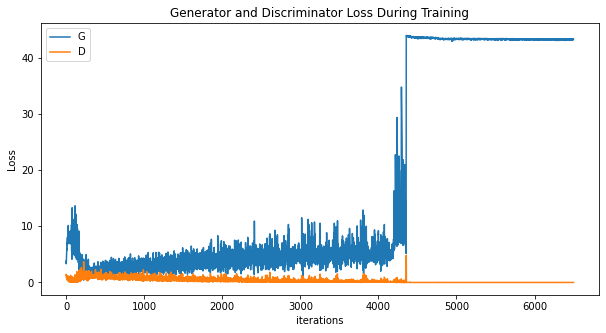

In [10]:
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=lr_dis, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_gen, betas=(0.5, 0.999))

#checkpoint = torch.load("/content/artifacts/128_CarGan_epoch49.tar")
#netG.load_state_dict(checkpoint['netG_state_dict'])
#netD.load_state_dict(checkpoint['netD_state_dict'])
#optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
#optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_dis, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_gen, betas=(beta1, 0.999))

netG.train()
netD.train()
print(netG)
print(netD)

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    print("epoch:",epoch)
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        image, file = data
        image = image.to(device)
        b_size = image.size(0)
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float32)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                   % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[0:16], padding = 2, normalize = True, nrow = 4))



        iters += 1


    fig = plt.figure(figsize = (12,12))
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=False)] for i in img_list]
    plt.savefig("/content/artifacts/" + str(epoch) + ".png")
    plt.close()
    torch.save({
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict()
        }, '/content/artifacts/128_CarGan_epoch' + str(epoch) + '.tar')




plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

'''
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())
'''



torch.save({
    'netG_state_dict': netG.state_dict(),
    'netD_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict()
    }, '/content/artifacts/128_CarGan.tar')

# sample = netG(fixed_noise).detach().cpu()
# vutils.make_grid(sample, padding=2, normalize=True)
# plt.imshow(np.transpose((1,2,0)))

In [ ]:
!zip -r /content/artifacts.zip /content/artifacts/

updating: content/artifacts/ (stored 0%)
  adding: content/artifacts/55.png (deflated 0%)
  adding: content/artifacts/128_CarGan_epoch53.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch82.tar (deflated 9%)
  adding: content/artifacts/54.png (deflated 0%)
  adding: content/artifacts/74.png (deflated 0%)
  adding: content/artifacts/128_CarGan_epoch25.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch28.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch79.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch68.tar (deflated 9%)
  adding: content/artifacts/81.png (deflated 0%)
  adding: content/artifacts/128_CarGan_epoch18.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch55.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch95.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch37.tar (deflated 9%)
  adding: content/artifacts/128_CarGan_epoch32.tar (deflated 9%)
  adding: content/artifacts/29.png (deflated 0%)